In [1]:
# import necessary libraries
import os, sys, glob
import math
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from PIL import Image
from importlib import reload # when you make changes to a .py, force reload imports


# custom imports
sys.path.append('../')

from utils.GetLowestGPU import GetLowestGPU
from utils.GetLR import get_lr
import utils.Train as Train
import utils.Plot as Plot
import utils.WeightedCrossEntropy as WeightedCrossEntropy
import utils.BuildUNet as BuildUNet
import utils.TileGenerator as TG
import utils.DistanceMap as DistanceMap

device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 07884MiB / 40537MiB
  1  | 00003MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:1
---------------------------


# 1) Data Loading / Plotting

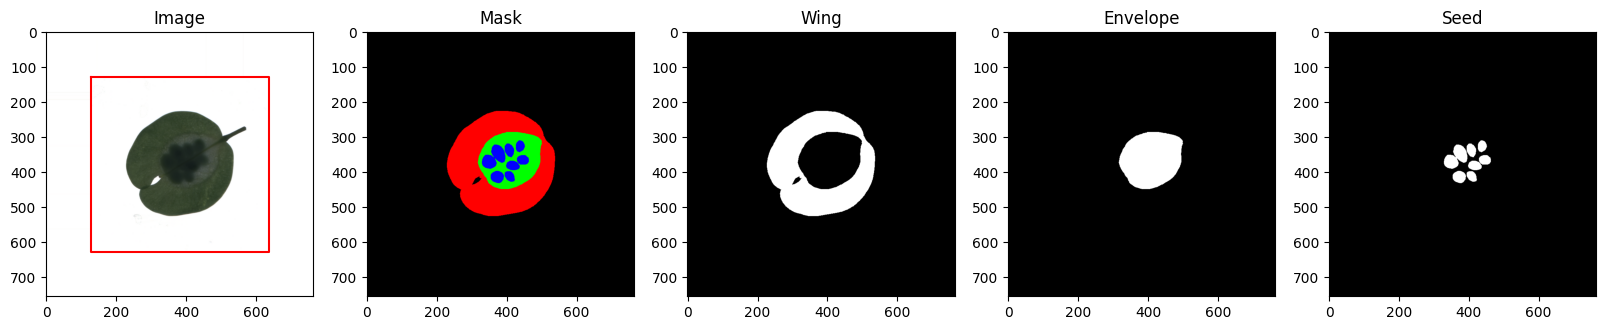

In [2]:
# define options
img_path = '../pennycress_pods/train/train_images_by_pod/'
mask_path = '../pennycress_pods/train/train_masks_by_pod/'
n_pad = 128

# load images and masks into list
mask_names = sorted([os.path.basename(x) for x in glob.glob(mask_path + '*.png')])

pennycress_images = []
pennycress_masks = []

# VISUALIZE
for img_name in mask_names:
    # load image
    image = np.array(Image.open(img_path + img_name))
    image = (image[:, :, :3] / 255.0) # normalize image
    image = np.pad(image, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'edge') # pad image w/ values on edge
    pennycress_images.append(image)

    # load mask
    mask = np.array(Image.open(mask_path + img_name))
    mask = (mask / 255.0) # normalize mask
    mask = np.pad(mask, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'constant', constant_values=0) # pad mask w/ constant 0 value
    pennycress_masks.append(mask)

# split masks into wing and pod and seed
wings = [m[:, :, 0] > 0.5 for m in pennycress_masks] # take red channel and booleanize
envelopes = [m[:, :, 1:].sum(-1) > 0.5 for m in pennycress_masks] # "... blue ..."
seeds = [m[:, :, 2] > 0.5 for m in pennycress_masks] # "... green ..."

# create list for multiclass masks
multiclass_masks = []

# add additional channel to pennycress masks for one-hot encoding
for mask in pennycress_masks:
    bg = mask.sum(-1) == 0 # booleanize background
    mask = np.concatenate([bg.reshape(*bg.shape, 1), mask], axis=-1) # add background channel
    multiclass_masks.append(mask)

# plot images and masks
i = np.random.randint(0, len(pennycress_images)) #select random from list of pennycress images
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(pennycress_images[i]); ax[0].set_title('Image')
# plot line around padding
ax[0].plot([n_pad, n_pad, pennycress_images[i].shape[1] - n_pad, pennycress_images[i].shape[1] - n_pad, n_pad],
           [n_pad, pennycress_images[i].shape[0] - n_pad, pennycress_images[i].shape[0] - n_pad, n_pad, n_pad], 'r')
ax[1].imshow(pennycress_masks[i]); ax[1].set_title('Mask')
ax[2].imshow(wings[i], cmap='gray'); ax[2].set_title('Wing')
ax[3].imshow(envelopes[i], cmap='gray'); ax[3].set_title('Envelope')
ax[4].imshow(seeds[i], cmap='gray'); ax[4].set_title('Seed')
plt.show()

# 2) Data Generation

Plotting training examples...


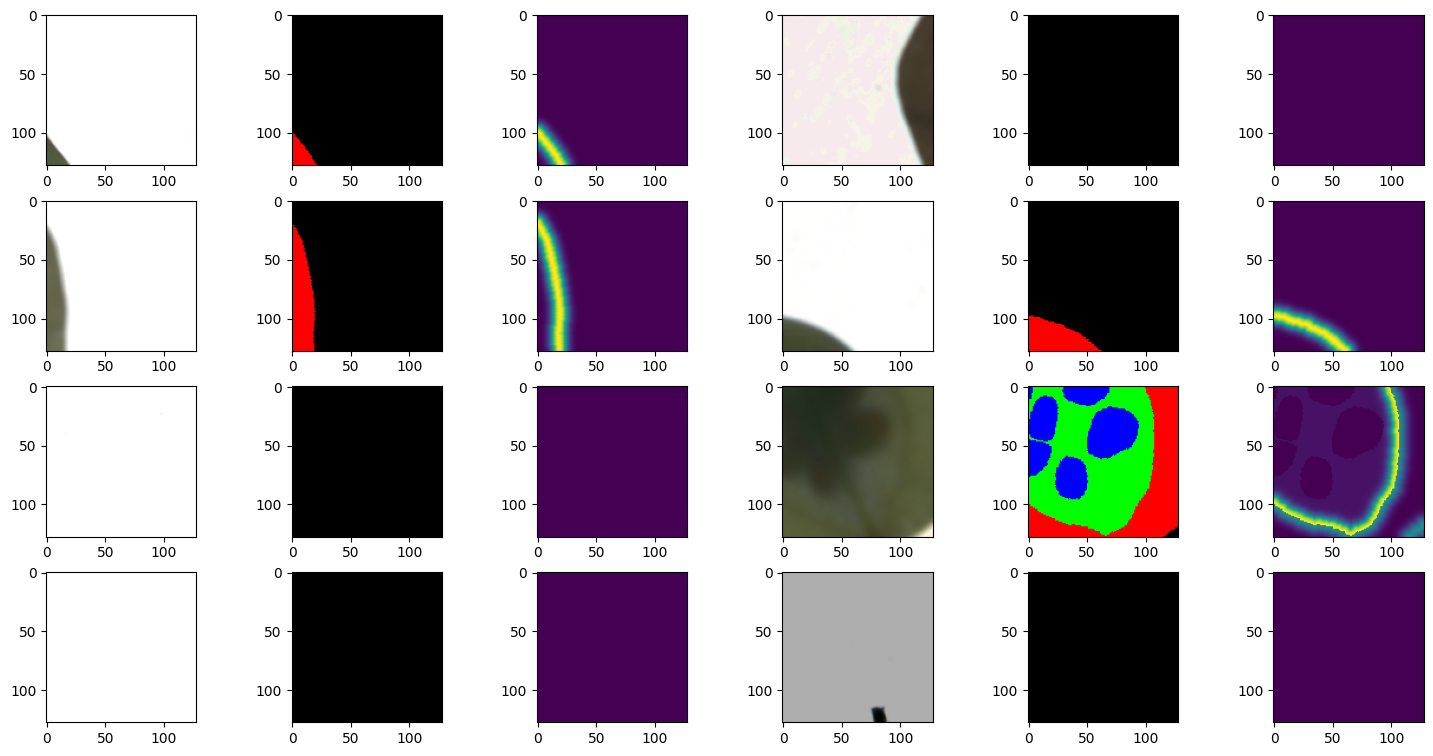

Plotting validation examples...


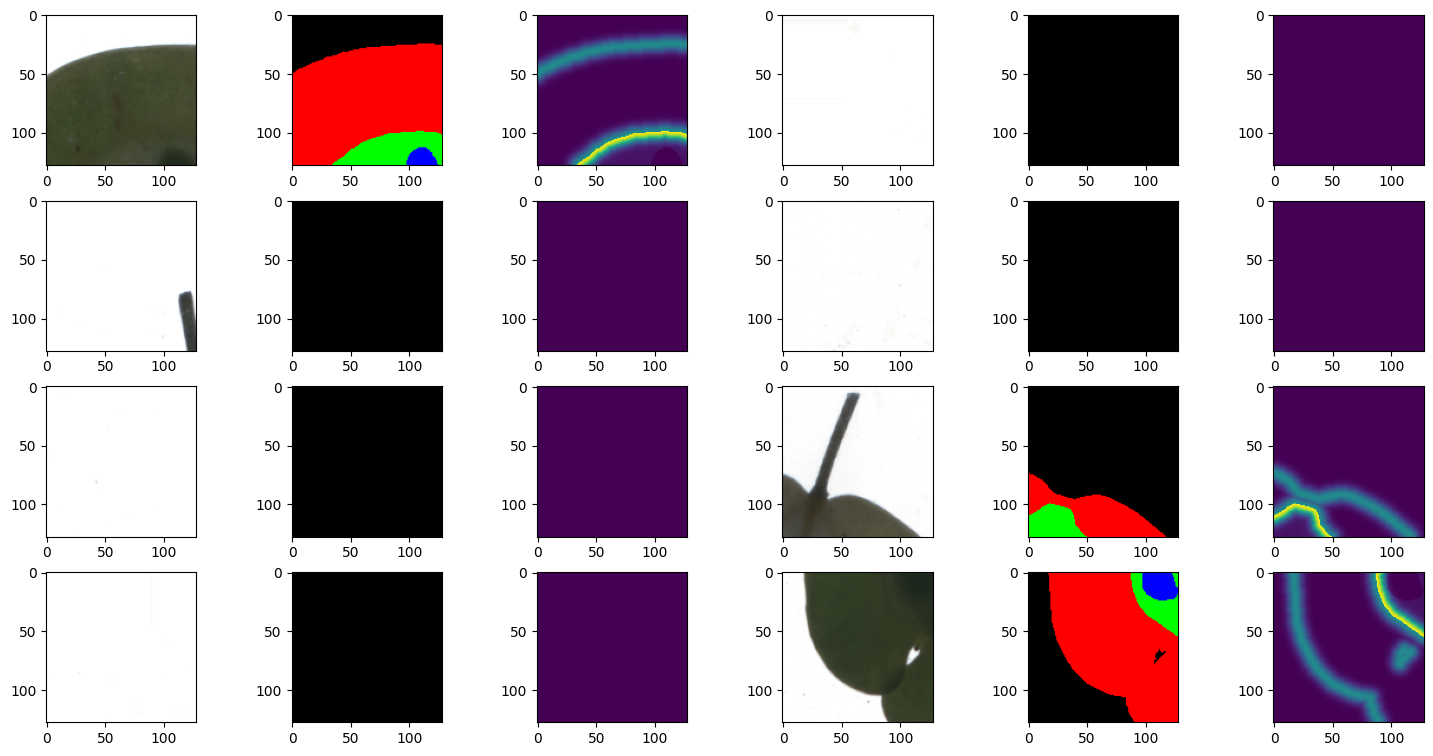

In [3]:
# whenever you run cell, re-import TG as a module
reload(TG)
reload(DistanceMap)

# options
images = pennycress_images
masks = multiclass_masks
tile_size = 128
train_prop = 0.8
distance_weights = True

#create train/val splits by image
p = np.random.permutation(len(images))
train_idx = p[:int(train_prop*len(images))]
val_idx = p[int(train_prop*len(images)):]

# instantiate tilegenerator class
train_generator = TG.TileGenerator(
    images=[images[i] for i in train_idx],
    masks=[masks[i] for i in train_idx], 
    tile_size=tile_size, 
    split='train',
    n_pad = n_pad,
    distance_weights=distance_weights
    )

val_generator = TG.TileGenerator(
    images=[images[i] for i in val_idx],
    masks=[masks[i] for i in val_idx], 
    tile_size=tile_size, 
    split='val',
    n_pad = n_pad,
    distance_weights=distance_weights
    )

#plot random samples
figsize = 15
np.random.seed(0)
    
print('Plotting training examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(train_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    if distance_weights:
        img, t = train_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = t[:-1, :, :].permute(1, 2, 0).numpy()[:, :, 1:]
        w = t[-1, :, :].numpy()

        ax = fig.add_subplot(4, 6, 3*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+2)
        plt.imshow(msk)
        ax = fig.add_subplot(4, 6, 3*i+3)
        plt.imshow(w)

    else:
        img, msk = train_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]
        
        ax = fig.add_subplot(4, 4, 2*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 4, 2*i+2)
        plt.imshow(msk, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

print('Plotting validation examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(val_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    if distance_weights:
        img, t = val_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = t[:-1, :, :].permute(1, 2, 0).numpy()[:, :, 1:]
        w = t[-1, :, :].numpy()

        ax = fig.add_subplot(4, 6, 3*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+2)
        plt.imshow(msk, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 6, 3*i+3)
        plt.imshow(w)

    else:
        img, msk = val_generator[rand_idx]
        img = img.permute(1, 2, 0).numpy()
        msk = msk.permute(1, 2, 0).numpy()[:, :, 1:]

        ax = fig.add_subplot(4, 4, 2*i+1)
        plt.imshow(img, vmin=0, vmax=1)
        ax = fig.add_subplot(4, 4, 2*i+2)
        plt.imshow(msk, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

# Build U-Net

In [4]:
reload(BuildUNet)

model_kwargs = {
    'layer_sizes': [16, 32, 64, 128, 256],
    'in_channels': 3,
    'out_channels': 4,
    'conv_per_block': 3,
    'dropout_rate': 0.1,
    'hidden_activation': torch.nn.SELU(),
    'output_activation': None
}

unet = BuildUNet.UNet(**model_kwargs).to(device)

# Train Model

In [5]:
# define our loss function, optimizer
reload(WeightedCrossEntropy)
if distance_weights:
    loss_function = WeightedCrossEntropy.WeightedCrossEntropy(device=device)
else:
    loss_function = torch.nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

In [6]:
reload(Train)

# log options
log_path = '../logs/log.csv'
chckpnt_path = '../checkpoints/checkpoint_{0}.pt'

# lr options
warmup_iters = 1000
lr_decay_iters = 50000
max_lr = 1e-3
min_lr = 1e-5
max_iters = 150000

Train.train_model(model = unet,
                  loss_function = loss_function,
                  optimizer = optimizer,
                  train_generator = train_generator,
                  val_generator = val_generator,
                  log_path = log_path,
                  chckpnt_path = chckpnt_path,
                  model_kwargs = model_kwargs,
                  train_idx = train_idx,
                  val_idx = val_idx,
                  device = device
                  )

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 0: train loss 7.7809e+00, val loss 7.5122e+00


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 1000: train loss 1.0727e+00, val loss 1.0685e+00
*** validation loss improved: 1.0685e+00 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 2000: train loss 7.9590e-01, val loss 7.9498e-01
*** validation loss improved: 7.9498e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 3000: train loss 7.4281e-01, val loss 7.0783e-01
*** validation loss improved: 7.0783e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 4000: train loss 7.0790e-01, val loss 6.8651e-01
*** validation loss improved: 6.8651e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 5000: train loss 6.6975e-01, val loss 6.3193e-01
*** validation loss improved: 6.3193e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 6000: train loss 6.6532e-01, val loss 6.4590e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 7000: train loss 6.5401e-01, val loss 6.3586e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 8000: train loss 6.5611e-01, val loss 6.3996e-01
validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 9000: train loss 6.0843e-01, val loss 6.0421e-01
*** validation loss improved: 6.0421e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 10000: train loss 6.0678e-01, val loss 5.9151e-01
*** validation loss improved: 5.9151e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 11000: train loss 6.0469e-01, val loss 5.8095e-01
*** validation loss improved: 5.8095e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 12000: train loss 5.7928e-01, val loss 5.6562e-01
*** validation loss improved: 5.6562e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 13000: train loss 6.3084e-01, val loss 6.4208e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 14000: train loss 5.5221e-01, val loss 5.5404e-01
*** validation loss improved: 5.5404e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 15000: train loss 4.8883e-01, val loss 4.7661e-01
*** validation loss improved: 4.7661e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 16000: train loss 4.6002e-01, val loss 4.4878e-01
*** validation loss improved: 4.4878e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 17000: train loss 4.0329e-01, val loss 3.8386e-01
*** validation loss improved: 3.8386e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 18000: train loss 3.5770e-01, val loss 3.5281e-01
*** validation loss improved: 3.5281e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 19000: train loss 3.4746e-01, val loss 3.4724e-01
*** validation loss improved: 3.4724e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 20000: train loss 3.5631e-01, val loss 3.4182e-01
*** validation loss improved: 3.4182e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 21000: train loss 3.2898e-01, val loss 3.2743e-01
*** validation loss improved: 3.2743e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 22000: train loss 3.5476e-01, val loss 3.4623e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 23000: train loss 3.3532e-01, val loss 3.2483e-01
*** validation loss improved: 3.2483e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 24000: train loss 3.0792e-01, val loss 3.1092e-01
*** validation loss improved: 3.1092e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 25000: train loss 3.0617e-01, val loss 3.1156e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 26000: train loss 3.1349e-01, val loss 3.1656e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 27000: train loss 2.9608e-01, val loss 2.9332e-01
*** validation loss improved: 2.9332e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 28000: train loss 2.9635e-01, val loss 2.9464e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 29000: train loss 2.9105e-01, val loss 2.9424e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 30000: train loss 2.8898e-01, val loss 2.9503e-01
validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 31000: train loss 2.8751e-01, val loss 2.8648e-01
*** validation loss improved: 2.8648e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 32000: train loss 2.8970e-01, val loss 2.8873e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 33000: train loss 2.8755e-01, val loss 2.9170e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 34000: train loss 2.9056e-01, val loss 2.9711e-01
validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 35000: train loss 2.8374e-01, val loss 2.8756e-01
validation has not improved in 4 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 36000: train loss 2.7481e-01, val loss 2.7931e-01
*** validation loss improved: 2.7931e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 37000: train loss 2.7488e-01, val loss 2.7593e-01
*** validation loss improved: 2.7593e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 38000: train loss 2.7354e-01, val loss 2.7787e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 39000: train loss 2.7173e-01, val loss 2.8372e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 40000: train loss 2.7442e-01, val loss 2.7980e-01
validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 41000: train loss 2.7094e-01, val loss 2.7642e-01
validation has not improved in 4 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 42000: train loss 2.6614e-01, val loss 2.7373e-01
*** validation loss improved: 2.7373e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 43000: train loss 2.6799e-01, val loss 2.7957e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 44000: train loss 2.6644e-01, val loss 2.7306e-01
*** validation loss improved: 2.7306e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 45000: train loss 2.6824e-01, val loss 2.8249e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 46000: train loss 2.6308e-01, val loss 2.7239e-01
*** validation loss improved: 2.7239e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 47000: train loss 2.6611e-01, val loss 2.7495e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 48000: train loss 2.6212e-01, val loss 2.6941e-01
*** validation loss improved: 2.6941e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 49000: train loss 2.6698e-01, val loss 2.7154e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 50000: train loss 2.6431e-01, val loss 2.7434e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 51000: train loss 2.6136e-01, val loss 2.6934e-01
*** validation loss improved: 2.6934e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 52000: train loss 2.6633e-01, val loss 2.6912e-01
*** validation loss improved: 2.6912e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 53000: train loss 2.6419e-01, val loss 2.6896e-01
*** validation loss improved: 2.6896e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 54000: train loss 2.5803e-01, val loss 2.6969e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 55000: train loss 2.5887e-01, val loss 2.7137e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 56000: train loss 2.6771e-01, val loss 2.7055e-01
validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 57000: train loss 2.6357e-01, val loss 2.7109e-01
validation has not improved in 4 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 58000: train loss 2.6252e-01, val loss 2.7490e-01
validation has not improved in 5 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 59000: train loss 2.6597e-01, val loss 2.7331e-01
validation has not improved in 6 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 60000: train loss 2.6007e-01, val loss 2.7170e-01
validation has not improved in 7 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 61000: train loss 2.6363e-01, val loss 2.7366e-01
validation has not improved in 8 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 62000: train loss 2.6590e-01, val loss 2.7068e-01
validation has not improved in 9 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 63000: train loss 2.6704e-01, val loss 2.6739e-01
*** validation loss improved: 2.6739e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 64000: train loss 2.6402e-01, val loss 2.6790e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 65000: train loss 2.5994e-01, val loss 2.7029e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 66000: train loss 2.6673e-01, val loss 2.6870e-01
validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 67000: train loss 2.6509e-01, val loss 2.7080e-01
validation has not improved in 4 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 68000: train loss 2.6097e-01, val loss 2.7251e-01
validation has not improved in 5 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 69000: train loss 2.6196e-01, val loss 2.7112e-01
validation has not improved in 6 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 70000: train loss 2.6167e-01, val loss 2.6645e-01
*** validation loss improved: 2.6645e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 71000: train loss 2.6133e-01, val loss 2.7540e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 72000: train loss 2.6295e-01, val loss 2.6641e-01
*** validation loss improved: 2.6641e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 73000: train loss 2.5934e-01, val loss 2.7338e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 74000: train loss 2.6223e-01, val loss 2.6663e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 75000: train loss 2.6052e-01, val loss 2.6875e-01
validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 76000: train loss 2.6663e-01, val loss 2.6743e-01
validation has not improved in 4 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 77000: train loss 2.6462e-01, val loss 2.6610e-01
*** validation loss improved: 2.6610e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 78000: train loss 2.5841e-01, val loss 2.7112e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 79000: train loss 2.6426e-01, val loss 2.6973e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 80000: train loss 2.6433e-01, val loss 2.6760e-01
validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 81000: train loss 2.6484e-01, val loss 2.7095e-01
validation has not improved in 4 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 82000: train loss 2.6067e-01, val loss 2.6912e-01
validation has not improved in 5 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 83000: train loss 2.5972e-01, val loss 2.7296e-01
validation has not improved in 6 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 84000: train loss 2.6063e-01, val loss 2.6897e-01
validation has not improved in 7 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 85000: train loss 2.6289e-01, val loss 2.7278e-01
validation has not improved in 8 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 86000: train loss 2.6106e-01, val loss 2.6651e-01
validation has not improved in 9 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 87000: train loss 2.6108e-01, val loss 2.6373e-01
*** validation loss improved: 2.6373e-01 ***


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 88000: train loss 2.6038e-01, val loss 2.7348e-01
validation has not improved in 1 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 89000: train loss 2.6185e-01, val loss 2.7069e-01
validation has not improved in 2 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 90000: train loss 2.5885e-01, val loss 2.6863e-01
validation has not improved in 3 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 91000: train loss 2.5754e-01, val loss 2.6811e-01
validation has not improved in 4 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 92000: train loss 2.6312e-01, val loss 2.7195e-01
validation has not improved in 5 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 93000: train loss 2.6640e-01, val loss 2.6851e-01
validation has not improved in 6 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 94000: train loss 2.6202e-01, val loss 2.7239e-01
validation has not improved in 7 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 95000: train loss 2.5863e-01, val loss 2.6743e-01
validation has not improved in 8 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 96000: train loss 2.5909e-01, val loss 2.6482e-01
validation has not improved in 9 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 97000: train loss 2.5815e-01, val loss 2.6880e-01
validation has not improved in 10 steps


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

 Eval:   0%|          | 0/1000 [00:00<?, ?it/s]

step 98000: train loss 2.6333e-01, val loss 2.6671e-01
validation has not improved in 11 steps

*** no improvement for 10 steps, stopping ***


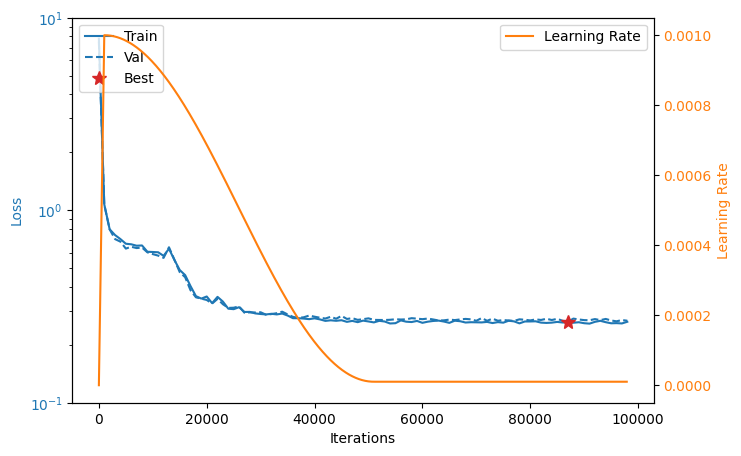

In [7]:
reload(Plot)
Plot.plot_loss(log_path='../logs/log.csv',
               warmup_iters=warmup_iters,
               lr_decay_iters=lr_decay_iters,
               max_lr=max_lr,
               min_lr=min_lr)

# Plot Input / Prediction Pairs on Val. Images

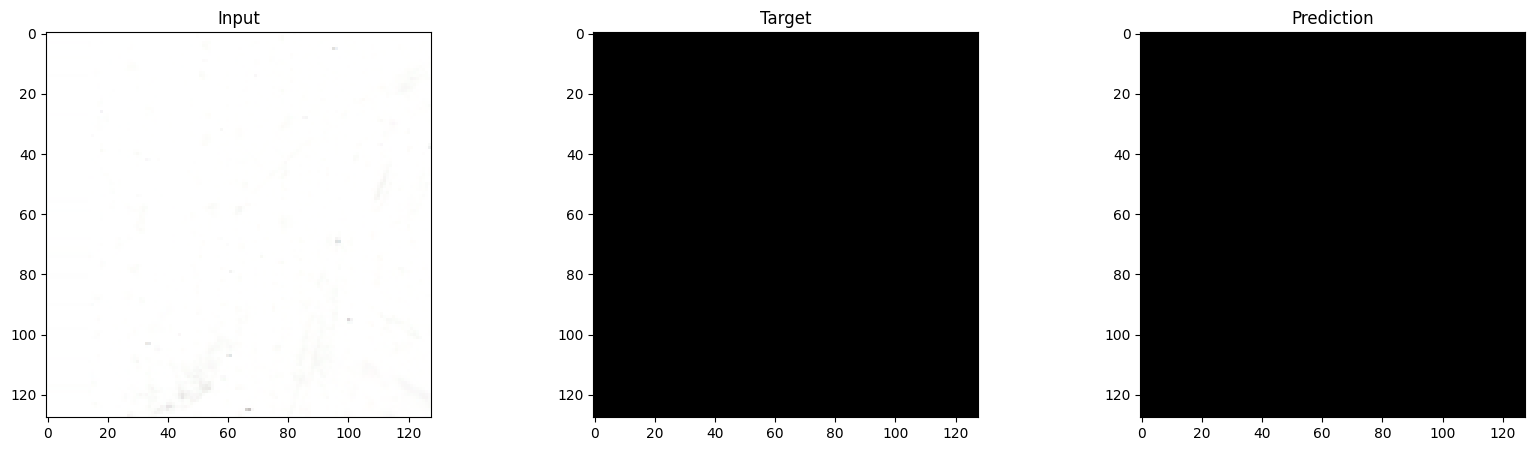

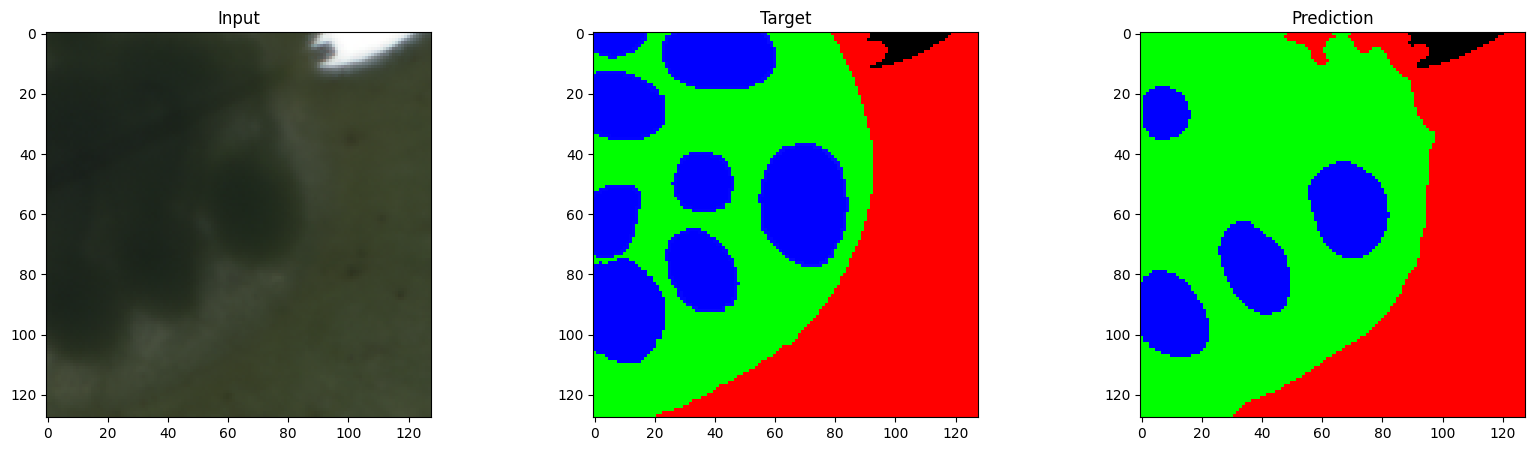

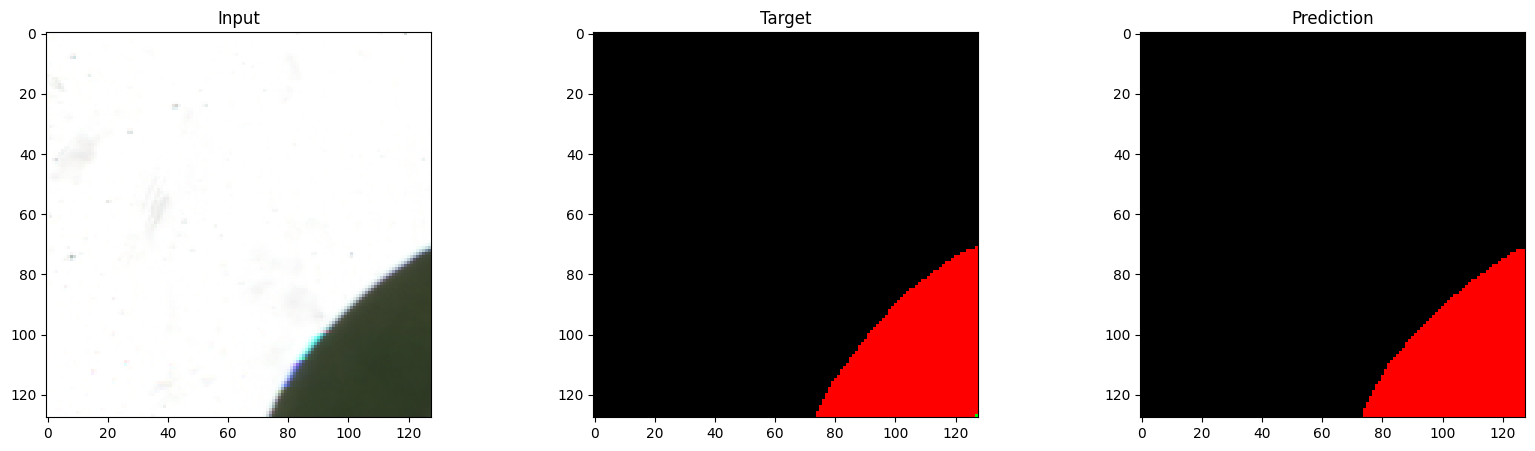

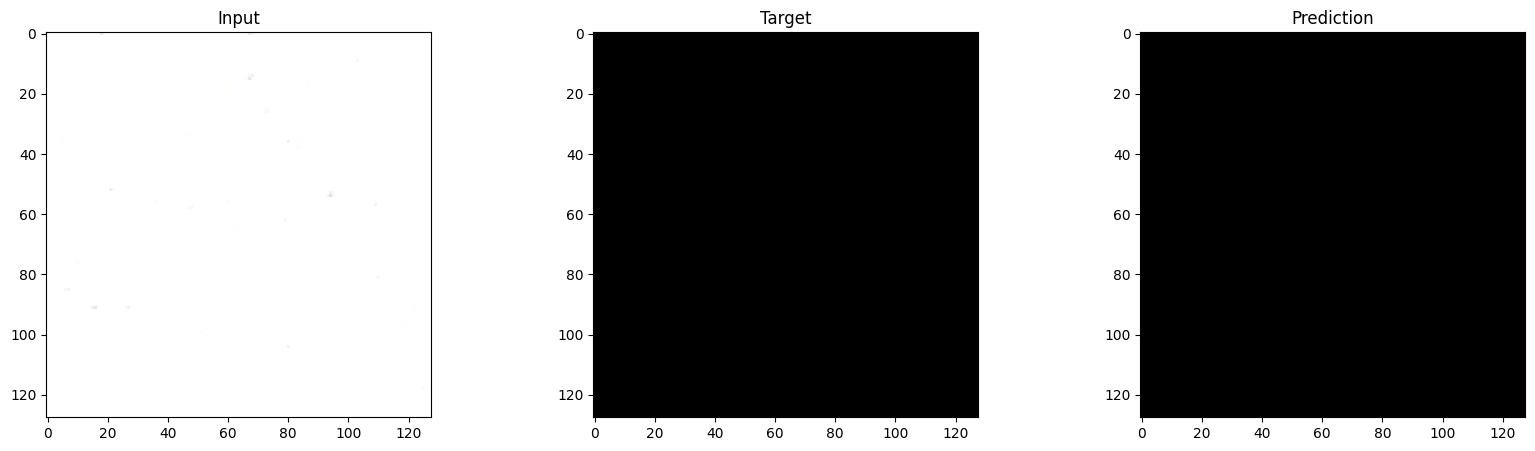

In [8]:
val_loader = DataLoader(
    val_generator, 
    batch_size=32, 
    shuffle=True,
    num_workers=32,
    pin_memory=True)

reload(Plot)
Plot.plot_val_images(val_loader=val_loader,
                     model=unet,
                     device=device)